In [1]:
import praw
import pandas as pd
from textblob import TextBlob
import datetime
import csv

/Users/andywang/Desktop/codes/TM_Final/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [12]:
class RedditTopPostCrawler:
    def __init__(self, client_id, client_secret, user_agent):
        self.reddit = praw.Reddit(
            client_id=client_id,
            client_secret=client_secret,
            user_agent=user_agent
        )
        
        self.election_keywords = [
            '2024 election', 'presidential race', 'vote', 'candidates', 
            'primary', 'democrat', 'republican', 'election day'
        ]
        
        self.candidates = [
            'Biden', 'Trump', 'Harris', 'DeSantis', 'Haley', 
            'Kennedy', 'Democratic Party', 'Republican Party'
        ]
    
    def clean_text(self, text):
        """
        Clean text to prevent CSV parsing issues
        
        Args:
            text (str): Input text to clean
        
        Returns:
            str: Cleaned text
        """
        if not isinstance(text, str):
            return ""
        
        # Replace newlines and tabs
        text = text.replace('\n', ' ').replace('\t', ' ')
        
        # Remove excessive whitespace
        text = ' '.join(text.split())
        
        return text
    
    def is_election_related(self, post_text):
        text = post_text.lower()
        
        keyword_matches = sum(
            2 if keyword in text else 0 
            for keyword in self.election_keywords
        )
        
        candidate_matches = sum(
            3 if name.lower() in text else 0 
            for name in self.candidates
        )
        
        blob = TextBlob(post_text)
        political_sentiment = abs(blob.sentiment.polarity) > 0.2
        
        relevance_score = keyword_matches + candidate_matches
        return relevance_score > 2 or political_sentiment
    
    def crawl_top_posts(self, subreddits=['politics', 'PoliticalDiscussion'], 
                         time_filter='year', 
                         max_posts_per_subreddit=100):
        """
        Retrieve top posts from specified subreddits for the current year
        
        Args:
            subreddits (list): List of subreddit names to crawl
            time_filter (str): Reddit's time filtering option
            max_posts_per_subreddit (int): Maximum posts to retrieve from each subreddit
        
        Returns:
            pandas.DataFrame: Filtered and processed top posts
        """
        all_posts_data = []
        
        for subreddit_name in subreddits:
            try:
                subreddit = self.reddit.subreddit(subreddit_name)
                
                # Retrieve top posts for the year
                for submission in subreddit.top(time_filter=time_filter, limit=max_posts_per_subreddit):
                    # Election content analysis
                    full_text = f"{submission.title} {submission.selftext}"
                    if self.is_election_related(full_text):
                        post_info = {
                            'subreddit': self.clean_text(subreddit_name),
                            'id': submission.id,
                            'title': self.clean_text(submission.title),
                            'text': self.clean_text(submission.selftext),
                            'author': self.clean_text(submission.author.name) if submission.author else 'Deleted',
                            'created_at': datetime.datetime.fromtimestamp(submission.created_utc),
                            'upvotes': submission.score,
                            'num_comments': submission.num_comments,
                            'url': submission.url,
                            'permalink': f"https://reddit.com{submission.permalink}"
                        }
                        all_posts_data.append(post_info)
            
            except Exception as e:
                print(f"Error crawling subreddit {subreddit_name}: {e}")
        
        return pd.DataFrame(all_posts_data)

    def save_to_csv(self, dataframe, filename='top_election_posts.csv'):
        """
        Save DataFrame to CSV with enhanced safety
        
        Args:
            dataframe (pandas.DataFrame): DataFrame to save
            filename (str): Output filename
        """
        dataframe.to_csv(
            filename, 
            index=False, 
            encoding='utf-8', 
            quoting=csv.QUOTE_ALL,  # Quote all fields
            escapechar='\\',  # Use escape character for special characters

        )

In [13]:
crawler = RedditTopPostCrawler(
    client_id='kiFX8s9VaCxF-UVSVolAPg',
    client_secret='f81xMcpVVsIkuS0GeppxXNgidHXj_g',
    user_agent='TM by AN'
)
    
    # Example: Crawl posts from January 1, 2024 to March 1, 2024
top_election_posts = crawler.crawl_top_posts(
        subreddits=['PoliticalDiscussion', 'Conservative', 'Liberal'],
        time_filter='year',
        max_posts_per_subreddit=10000
    )
    
crawler.save_to_csv(top_election_posts, 'top_election_posts_2024_1.csv')    

In [14]:
#read the csv file
df = pd.read_csv('top_election_posts_2024_1.csv')

#display max and min date of each subreddit
df['created_at'] = pd.to_datetime(df['created_at'])
df.groupby('subreddit')['created_at'].agg(['min', 'max'])

#display the number of posts in each subreddit
df['subreddit'].value_counts()

#print them
print(df['subreddit'].value_counts())
print(df.groupby('subreddit')['created_at'].agg(['min', 'max']))

subreddit
PoliticalDiscussion    790
Liberal                712
Conservative           523
Name: count, dtype: int64
                                    min                 max
subreddit                                                  
Conservative        2023-12-03 12:14:22 2024-11-28 06:37:52
Liberal             2023-12-02 23:34:11 2024-11-29 04:40:10
PoliticalDiscussion 2023-12-01 07:50:57 2024-11-29 11:58:12


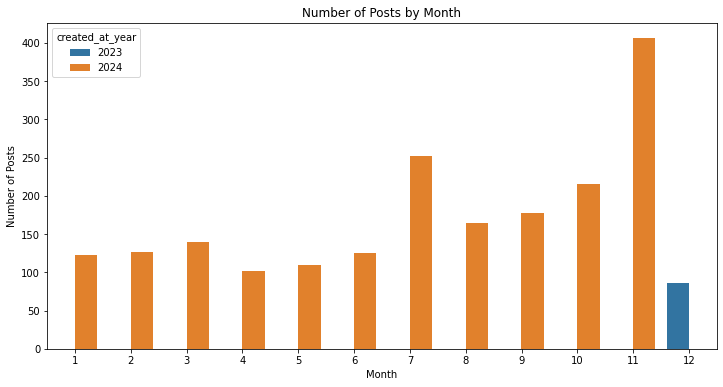

In [15]:
#plot the number of posts and time
import matplotlib.pyplot as plt
import seaborn as sns

df['created_at'] = pd.to_datetime(df['created_at'])
df['created_at_date'] = df['created_at'].dt.date
df['created_at_month'] = df['created_at'].dt.month
df['created_at_year'] = df['created_at'].dt.year

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='created_at_month', hue='created_at_year')
plt.title('Number of Posts by Month')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.show()

